# Does player as white really have an advantage against player as black?

As a chess player myself, I want to know and understand what makes a player, as black or white, win the game. Does the player as white always have the advantage? Throughout history, chess grandmasters and statistians have been debating whether white has the advantage, so I wanted to give it a try and find out.

### Objectives
We need to find out:
1. Relationship between times of winning, turns, color, and ratings <br><br>
2. Relationship between how the player wins and the color<br><br>
3. Relationship between game rating and probability of white winning<br><br>
4. How does opening move determine white's win rate?

### Import libraries and data
Before we begin crunching the numbers, we have to first import the libraries and data

In [2]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Import dataset
df = pd.read_csv("chess.csv")

### Dataset Overview
Inside this dataset contains information about approximately 20000 games in 2017, played by the top 100 teams in Lichess.

In [3]:
#Shows the amount of rows and columns of the dataframe
print(df.shape)

(20058, 16)


In [4]:
#prints the summary of the dataframe's information
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


In [5]:
#prints the top 5 games of the dataset
print(df.head())

         id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   
2  mIICvQHh   True  1.504130e+12  1.504130e+12     61           mate  white   
3  kWKvrqYL   True  1.504110e+12  1.504110e+12     61           mate  white   
4  9tXo1AUZ   True  1.504030e+12  1.504030e+12     95           mate  white   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adivanov2009          1469   

                                               moves opening_e

### Data Manipulation
To analyze it better, we would need to fix the dataframe a bit

According to <a href = "https://support.chess.com/article/330-why-are-there-different-ratings-in-live-chess#:~:text=We%20keep%20these%20rating%20separate,not%20just%20the%20base%20minutes">chess.com</a>, live chess has 3 ratings based on different time controls:
* <b>Bullet rating</b> - For games <3 minutes <br><br>
* <b>Blitz rating</b> - For games >3 minutes but <10 minutes <br><br>
* <b>Rapid rating</b> - For games >10 minutes<br><br>
This system assumes a 40 move average game-length to estimate the total length of time available.

So now, in order to make the dataframe more detailed, we can create a new column "game_rating" that contains the game ratings


$$EstimatedGameTime = Time + \frac{Increment * 40}{60} $$

To get the time and increment, we need the "increment_code" column and split it into "time" and "increment"

In [6]:
#splitting the increment code through slicing
plus = []
for i in range(len(df)):
    p = df['increment_code'][i].find('+')
    plus.append(p)
    p = 0

time = []
increment = []

for i in range(len(df)):
    tstring = df['increment_code'][i][0:plus[i]]
    istring = df['increment_code'][i][plus[i]+1:len(df['increment_code'][i])]
    time.append(tstring)
    increment.append(istring)

df['Time'] = [int(i) for i in time]
df['increment']= [int(i) for i in increment]

In [22]:
df['est_time'] = round((df['Time'] + ((df['increment'] * 40)/60)))

df['game_rating'] = df['est_time']
df['game_rating'] = df['game_rating'].apply(lambda x:'bullet' if x < 3 else('blitz' if x < 10 else 'rapid'))

#Converting game_rating into categorical data for future use
ratings = ['bullet', 'blitz', 'rapid']
ratings_cat = pd.api.types.CategoricalDtype(categories = ratings, ordered = True)
df['game_rating'] = df['game_rating'].astype(ratings_cat)

Now that we have the necessary columns, we can start approaching the objectives.

### Relationship between win counts, turns and ratings

First, I find the relationship between ratings, number of turns, and white's winning possibility

White total wins: 1005
Black total wins: 924
Draws: 71
White rating disadvantage wins: 360
Black rating disadvantage wins: 323
White win rating difference standard deviation: 256.08088674638145
Black win rating difference standard deviation: 255.3149605159185


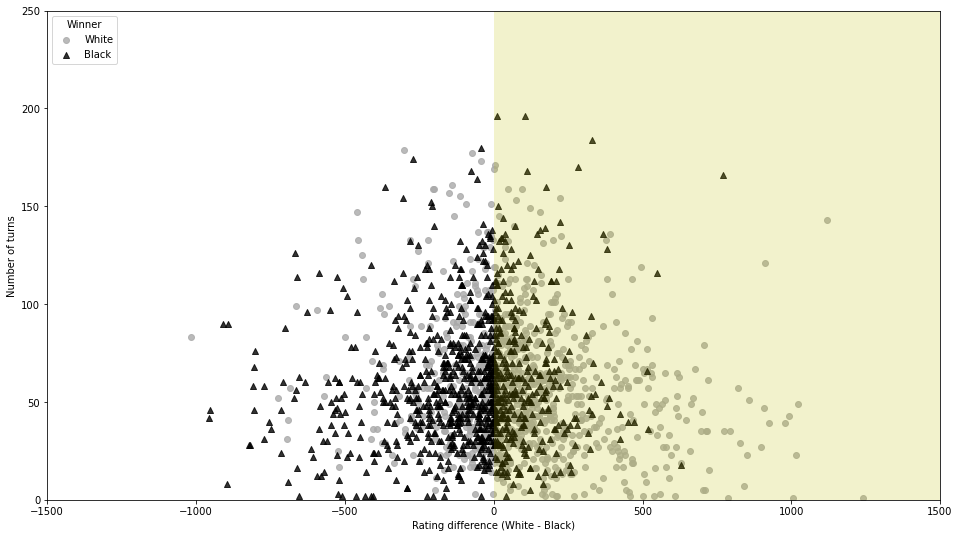

In [8]:
df['rating_diff'] = list(map(lambda x, y: x - y, df['white_rating'], df['black_rating']))

#Make a sample of data for scatterplot
df_sample = df.sample(2000, replace = False, random_state = 100)
df_sample.reset_index(drop=True, inplace=True)

winner_markers = [['white', 'o', 'darkgray'], ['black', '^', 'black']]

plt.figure(figsize = (16, 9))
for win, marker, color in winner_markers:
    sns.regplot(data = df_sample.loc[df_sample['winner']==win], x = 'rating_diff', y='turns', x_jitter = 5, fit_reg = False, marker = marker, scatter_kws = {'color': color});
plt.legend(title = 'Winner', labels = ['White', 'Black'])
plt.axvspan(0, max(df['rating_diff']), facecolor = 'y', alpha = 0.2)
plt.xlim(-1500, 1500)
plt.ylim(0, 250)
plt.xlabel('Rating difference (White - Black)')
plt.ylabel('Number of turns')

#Turn a tuple into a list
whiteWin = []
blackWin = []
for i in range(len(df_sample)):
    if df['winner'][i] == 'white':
        whiteWin.append(df_sample['rating_diff'][i])
    elif df['winner'][i] == 'black':
        blackWin.append(df_sample['rating_diff'][i])

#printing results
print("White total wins: " + str(list(df_sample['winner']).count('white')))
print("Black total wins: " + str(list(df_sample['winner']).count('black')))
print("Draws: " + str(list(df_sample['winner']).count('draw')))
print("White rating disadvantage wins: " + str(list(df_sample.query('rating_diff < 0')['winner']).count('white')))
print("Black rating disadvantage wins: " + str(list(df_sample.query('rating_diff > 0')['winner']).count('black')))
print("White win rating difference standard deviation: " + str(np.std(whiteWin)))
print("Black win rating difference standard deviation: " + str(np.std(blackWin)))

#### Observations
Within this plot, I found a few interesting things:
* White wins more than black, even during a disadvantage
* With a slightly higher standard deviation, white's wins are slightly more evenly distributed across rating differences compared to black's

While this shows that white may have a slight advantage, the analysis is not fully completed. 

### Relationship between victory status and winning color
To further on our analysis, we can check the relationship between victory status and winning color

To find if white has an advantage over black, we can use <b>Bayes' Theorem</b>, a formula to find out the probability given a prior knowledge of condition. <br>The formula of Bayes' Theorem:
$$P(A|B) = \frac{P(B|A) * P(A)}{P(B)}$$
where:
* P(A|B) is the probability of event A happening given that B is true.
* P(B|A) is the probability of event B happening given that A is true.
* P(A) and P(B) are the probabilities of observing A and B respectively, known as the marginal probability.
* A and B must be different events

Through finding the probability of white winning given a victory status, I can tell whether white has an advantage throughout all or if only some of them.

#### Probability of white winning given they win through resign
To begin the analysis, I found the conditional probability of winning through resigning, given that the winner will be the player as white. <br>
Conditional probability formula:
$$P(B|A) = \frac{P(B\cap A)}{P(A)}$$<br>
In the following, white winning will be P(A) and winning through resigning will be P(B):

In [9]:
#Add 2 boolean variables to create pivot table
df['win_resign'] = np.where(df['victory_status'] == 'resign', 1, 0)
df['whiteWin'] = np.where(df['winner'] == 'white', 1, 0)

#Add a column to build a pivot table easier
df['count'] = 1

#Create df1 to drop other columns
df1 = df[['whiteWin', 'win_resign', 'count']]

#create pivot table
pd.pivot_table(df1, values = 'count', index = ['whiteWin'], columns = ['win_resign'], aggfunc = np.size, fill_value = 0)

win_resign,0,1
whiteWin,,
0,4754,5303
1,4157,5844


Now that we have all the data we need, we can start by calculating each part of the formula

In [10]:
resign_probA = (4157 + 5884)/(4157 + 5303 + 4754 + 5844)
resign_probB = (5303 + 5844)/(4754 + 5303 + 4157 + 5844)
resign_bna = 5844 / (4754 + 5303 + 4157 + 5844)

And now we can plug in the values into the formula for conditional probability

In [11]:
resign_probBgivA = resign_bna / resign_probA
print("Probability of win condition given white wins: " + str(resign_probBgivA * 100) + "%")

Probability of win condition given white wins: 58.201374365103085%


Now that probability of A, probability of B, and probability of B given A is here, we can plug all the values into the Bayes' theorem

In [12]:
resign_probAgivB = (resign_probBgivA * resign_probA)/resign_probB
print("Probability of white wins given winning condition is resigning: " + str(resign_probAgivB*100) + "%")

Probability of white wins given winning condition is resigning: 52.426661882120754%


After understand the probability of white wins given winning condition is resigning, I repeated the procedure two more times.
One for checkmate, and one for timeout.

In [13]:
#Find probability for white winning given that it's winning by checkmate
df['win_mate'] = np.where(df['victory_status'] == 'mate', 1, 0)
df['whiteWin'] = np.where(df['winner'] == 'white', 1, 0)


df['count'] = 1


df1 = df[['whiteWin', 'win_mate', 'count']]


pd.pivot_table(df1, values = 'count', index = ['whiteWin'], columns = ['win_mate'], aggfunc = np.size, fill_value = 0)

win_mate,0,1
whiteWin,,
0,7076,2981
1,6657,3344


In [14]:
mate_probA = (6657 + 3344)/(6657 + 3344 + 7076 + 2981)
mate_probB = (2981 + 3344)/(6657 + 3344 + 7076 + 2981)
mate_bna = 3344 / (6657 + 3344 + 7076 + 2981)
mate_probBgivA = mate_bna / mate_probA
mate_probAgivB = (mate_probBgivA * mate_probA)/mate_probB
print("Probability of white wins given winning condition is checkmate: " + str(mate_probAgivB*100) + "%")

Probability of white wins given winning condition is checkmate: 52.8695652173913%


In [15]:
#Find probability for white winning given that it's winning by timeout
df['win_out'] = np.where(df['victory_status'] == 'outoftime', 1, 0)
df['whiteWin'] = np.where(df['winner'] == 'white', 1, 0)


df['count'] = 1


df1 = df[['whiteWin', 'win_out', 'count']]


pd.pivot_table(df1, values = 'count', index = ['whiteWin'], columns = ['win_out'], aggfunc = np.size, fill_value = 0)

win_out,0,1
whiteWin,,
0,9190,867
1,9188,813


In [16]:
out_probA = (9188 + 813)/(9190 + 9188 + 813 + 867)
out_probB = (867 + 813)/(9190 + 9188 + 813 + 867)
out_bna = 813 / (9190 + 9188 + 813 + 867)
out_probBgivA = out_bna / out_probA
out_probAgivB = (out_probBgivA * out_probA)/out_probB
print("Probability of white wins given winning condition is timeout: " + str(out_probAgivB*100) + "%")

Probability of white wins given winning condition is timeout: 48.392857142857146%


While white does have an advantage when winning through checkmate, white's probability of winning by timeout is approximately 48%. Though this does not mean that black is on the advantage side yet, for there is still draw if the other does not have sufficient mating material.

In [17]:
#Find probability for white winning given that it's winning by timeout
df['win_out'] = np.where(df['victory_status'] == 'outoftime', 1, 0)
df['blackWin'] = np.where(df['winner'] == 'black', 1, 0)


df['count'] = 1


df1 = df[['blackWin', 'win_out', 'count']]


pd.pivot_table(df1, values = 'count', index = ['blackWin'], columns = ['win_out'], aggfunc = np.size, fill_value = 0)

win_out,0,1
blackWin,,
0,10094,857
1,8284,823


In [18]:
b_out_probA = (10094 + 8284)/(10094 + 8284 + 823 + 857)
b_out_probB = (857 + 823)/(10094 + 8284 + 823 + 857)
b_out_bna = 823 / (10094 + 8284 + 823 + 857)
b_out_probBgivA = b_out_bna / b_out_probA
b_out_probAgivB = (b_out_probBgivA * b_out_probA)/b_out_probB
print("Probability of black wins given winning condition is timeout: " + str(b_out_probAgivB*100) + "%")

Probability of black wins given winning condition is timeout: 48.988095238095234%


#### Observations
After a little bit of analysis, I notice that:
* White has an advantage if player wants to win through opponent resigning
* White has an advantage if player wants to win through checkmate
* Black has a slight advantage if player wants to win through timeout

While white does not get all the advantages, it does have an advantage. But we are only halfway through the analysis, so black still has a chance.

### Relationship between game_rating and winning color
First we need to find out how many players are playing for each game_rating

(-1.1074971767611945,
 1.1066263914151002,
 -1.1034061716609131,
 1.1107173965153816)

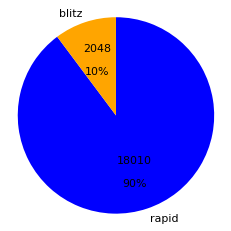

In [28]:
df['game_rating'] = df['game_rating'].cat.remove_unused_categories()
rating_count = df['game_rating'].value_counts()

#define a function for pie plotting
def pie_abs(x):
    absolute = int(round(x / 100*df.shape[0], 0))
    return "{}\n\n{:0.0f}%".format(absolute, x)

#Plot pie chart
plt.pie(data = df,x = rating_count, labels = rating_count.index, startangle = 90,
        counterclock = False, autopct = pie_abs, textprops = dict(fontsize = 11),
        colors = ['blue', 'orange'])

#Set the axis to a square
plt.axis('square')

It looks like 90% of the games are rapid, 10% of the games are blitz, and none of the games are bullet. 

Now let's take a look at the relationship between winner count and the game rating.

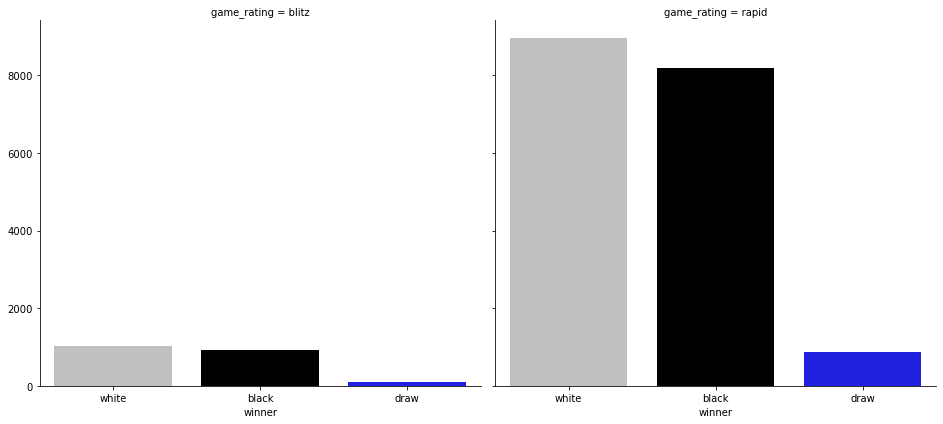

In [45]:
p = sns.FacetGrid(data = df, col = 'game_rating', height = 6, aspect=1.1)
p.map(sns.countplot, 'winner', order=['white', 'black', 'draw'], palette=['silver','black', 'blue']); 

#### Observations
After looking at the graph, there are 2 main points that I noticed:
* White beats black in terms of advantage for both blitz and rapid
* While black is beaten in advantage in both ratings, black's disadvantage in blitz is way less in comparison to rapid

At this point, the result is starting to take shape, seeming that white does have an advantage, but we are not finished yet, we still have the last analysis.

### Relationship between opening move and winning color
There are lots of opening moves in chess, from queen's gambit to silican defense to king's gambit (my favourate opening move). But does white have an advantage, even with strategies and opening moves? <br><br>
To start the analysis, we first need to find the eco. According to <a href = "https://www.365chess.com/eco.php">365Chess</a>, openings are divided into five categories from "A" to "E". To do that, we can find the first letter of the "opening_eco" for each match, and use that to categorize the eco rating. 

In [50]:
df['eco_cat'] = df['opening_eco'].apply(lambda x: x[0])
#convert eco_cat into categorical data
op = ['A', 'B', 'C', 'D', 'E']
op_cat = pd.api.types.CategoricalDtype(categories = op, ordered = True)
df['eco_cat'] = df['eco_cat'].astype(op_cat)

Now that we categorized the openings, we can start the analysis.

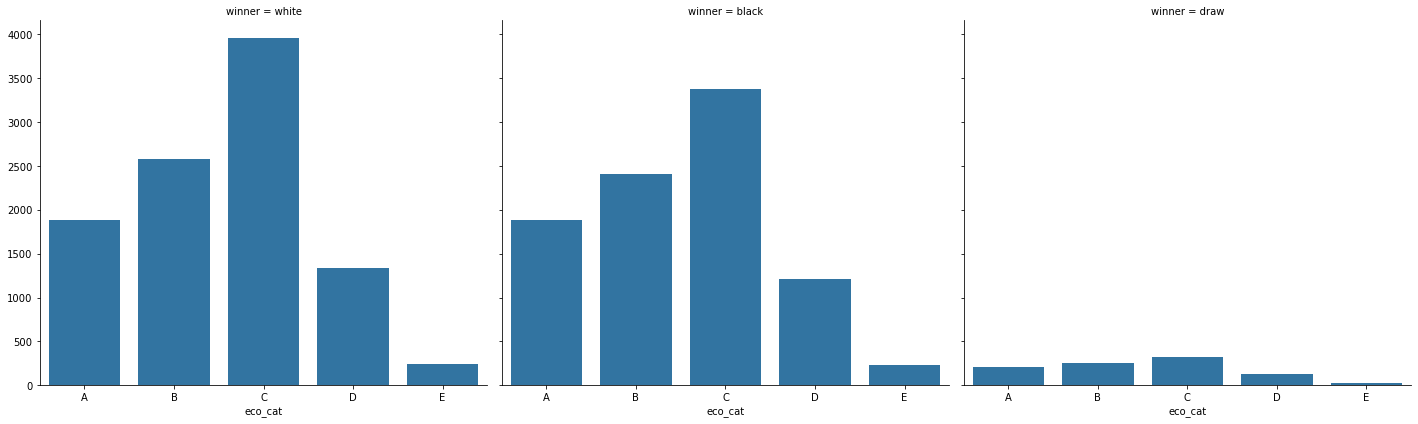

In [58]:
g = sns.FacetGrid(data = df, col = 'winner', height = 6, aspect=1.1)
g.map(sns.countplot, 'eco_cat', order = ['A', 'B', 'C', 'D', 'E'])

Now let's look at each opening category in detail by reversing the columns and x

Opening category A statistics: 
Opening A frequency: 19.807558081563467%
white wins: 1888
black wins: 1878
draws: 207

Opening category B statistics: 
Opening B frequency: 26.114268620999102%
white wins: 2576
black wins: 2406
draws: 256

Opening category C statistics: 
Opening C frequency: 38.17928008774554%
white wins: 3957
black wins: 3375
draws: 326

Opening category D statistics: 
Opening D frequency: 13.376208993917638%
white wins: 1337
black wins: 1216
draws: 130

Opening category E statistics: 
Opening E frequency: 2.522684215774255%
white wins: 243
black wins: 232
draws: 31

white total wins: 10001
black total wins: 9107


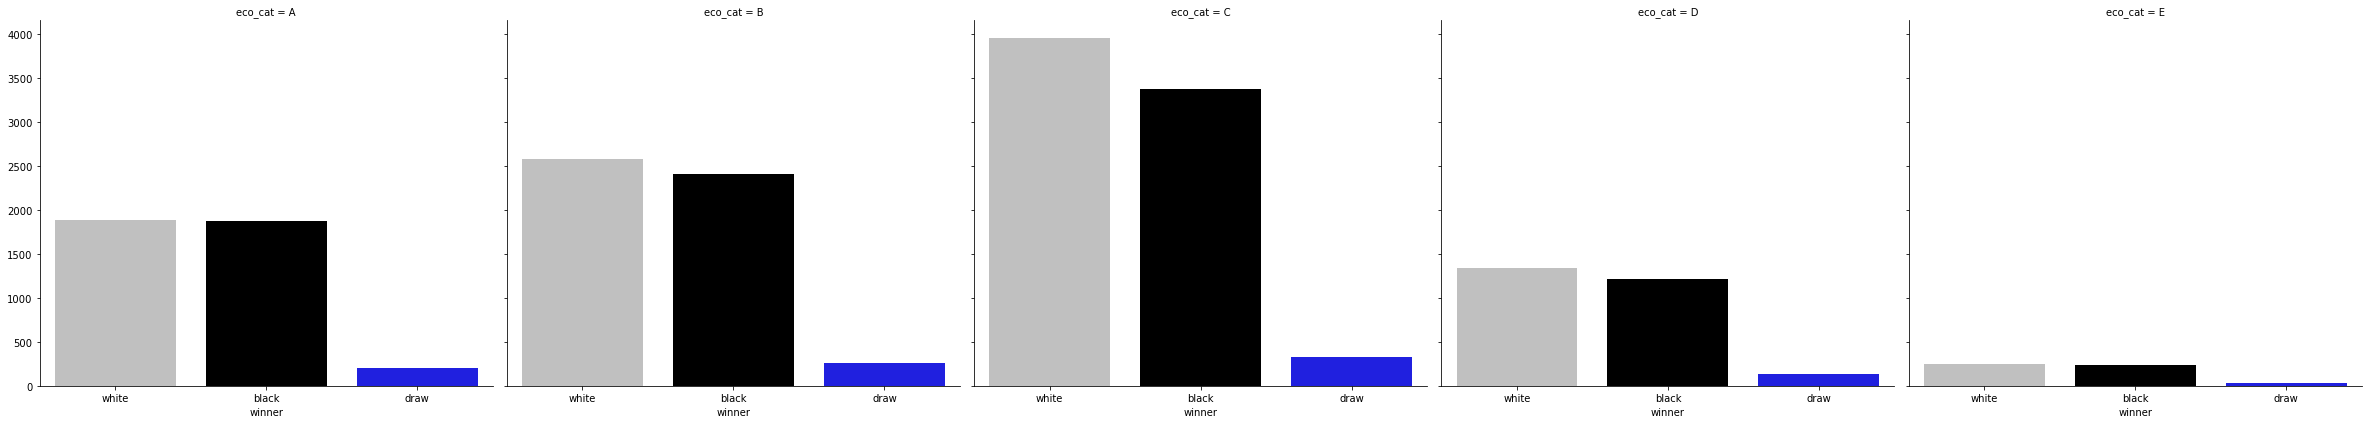

In [83]:
h = sns.FacetGrid(data = df, col = 'eco_cat', height = 6, aspect=1.1)
h.map(sns.countplot, 'winner', order = ['white', 'black', 'draw'], palette = ['silver', 'black', 'blue'])
print("Opening category A statistics: ")
print("Opening A frequency: " + str(list(df['eco_cat']).count("A")*100 / len(df['eco_cat'])) + "%")
print("white wins: " + str(list(df.query('eco_cat == "A"')['winner']).count('white')))
print("black wins: " + str(list(df.query('eco_cat == "A"')['winner']).count('black')))
print("draws: " + str(list(df.query('eco_cat == "A"')['winner']).count('draw')))
print()
print("Opening category B statistics: ")
print("Opening B frequency: " + str(list(df['eco_cat']).count("B")*100 / len(df['eco_cat'])) + "%")
print("white wins: " + str(list(df.query('eco_cat == "B"')['winner']).count('white')))
print("black wins: " + str(list(df.query('eco_cat == "B"')['winner']).count('black')))
print("draws: " + str(list(df.query('eco_cat == "B"')['winner']).count('draw')))
print()
print("Opening category C statistics: ")
print("Opening C frequency: " + str(list(df['eco_cat']).count("C")*100 / len(df['eco_cat'])) + "%")
print("white wins: " + str(list(df.query('eco_cat == "C"')['winner']).count('white')))
print("black wins: " + str(list(df.query('eco_cat == "C"')['winner']).count('black')))
print("draws: " + str(list(df.query('eco_cat == "C"')['winner']).count('draw')))
print()
print("Opening category D statistics: ")
print("Opening D frequency: " + str(list(df['eco_cat']).count("D")*100 / len(df['eco_cat'])) + "%")
print("white wins: " + str(list(df.query('eco_cat == "D"')['winner']).count('white')))
print("black wins: " + str(list(df.query('eco_cat == "D"')['winner']).count('black')))
print("draws: " + str(list(df.query('eco_cat == "D"')['winner']).count('draw')))
print()
print("Opening category E statistics: ")
print("Opening E frequency: " + str(list(df['eco_cat']).count("E")*100 / len(df['eco_cat'])) + "%")
print("white wins: " + str(list(df.query('eco_cat == "E"')['winner']).count('white')))
print("black wins: " + str(list(df.query('eco_cat == "E"')['winner']).count('black')))
print("draws: " + str(list(df.query('eco_cat == "E"')['winner']).count('draw')))
print()
print("white total wins: "+ str(list(df['winner']).count('white')))
print("black total wins: "+ str(list(df['winner']).count('black')))

#### Observation
The results show that:
* No matter what opening category, white has an advantage over black, with opening category C being the biggest advantage, and opening category A being the least advantage.
* With a frequency of approximately 38%, players tend to play opening category C the most, meaning white has a 38% chance of having the biggest advantage

### Results
After the analysis, it is clear that white does have an advantage over black, no matter which opening you are playing or which game rating you are playing, with black's only advantage being when you try to win by timeout.

This is just an overview of whether white does have an advantage over black. To look further into the probabilities and statistics, it will require more complex probability models.